# 3. Personalized Interest Rate (K-mean)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle as pk
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

pd.options.display.float_format = '{:,.4f}'.format #set the display format of the numbers

In [24]:
loandata = pd.DataFrame(pd.read_csv('cleaned_loan_data.csv'))
loandata.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,assets,loan_status
0,2,1,0,9600000,29900000,12,778,50700000,1
1,0,0,1,4100000,12200000,8,417,17000000,0
2,3,1,0,9100000,29700000,20,506,57700000,0
3,3,1,0,8200000,30700000,8,467,52700000,0
4,5,0,1,9800000,24200000,20,382,55000000,0


# Train the model

In [ ]:
# Selecting relevant features for clustering
loandata_approved = loandata[loandata["loan_status"] == 1] #filter only approved loans
x = loandata_approved[["income_annum", "loan_amount"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Hyper Parameter tuning & Model Evaluation

In [ ]:
# try to find the optimal number of clusters
wcss = []
k_values = range(1, 11)
for k in k_values: 
    model_k = KMeans(n_clusters=k, random_state=42, n_init=10)
    model_k.fit(X_scaled)
    wcss.append(model_k.inertia_)

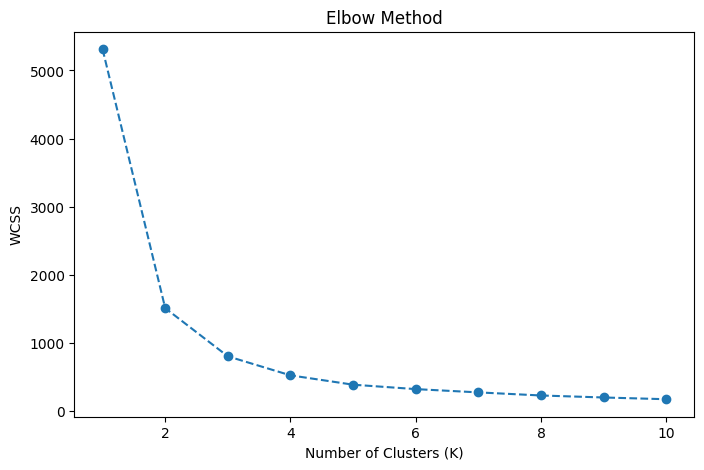

In [26]:
# Draw the Elbow to find the optimal number for K
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [27]:
# using the elbow plot, we can see that the optimal number of clusters is 2
model = KMeans(n_clusters=4, random_state=42, n_init=10)
loandata_approved["Cluster"] = model.fit_predict(X_scaled)

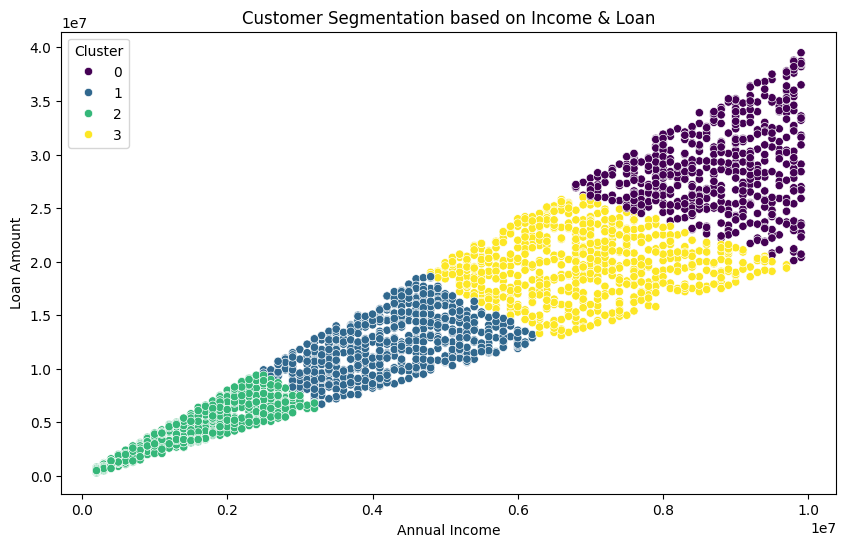

Cluster
2    734
1    705
3    697
0    520
Name: count, dtype: int64


In [28]:
# Cluster Analysis Visualization only for approved loans
plt.figure(figsize=(10, 6))
sns.scatterplot(x=loandata_approved["income_annum"], y=loandata_approved["loan_amount"], hue=loandata_approved["Cluster"], palette="viridis")
plt.xlabel("Annual Income")
plt.ylabel("Loan Amount")
plt.title("Customer Segmentation based on Income & Loan")
plt.show()

# Display sample cluster counts
print(loandata_approved["Cluster"].value_counts())

In [29]:
loandata_approved.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,assets,loan_status,Cluster
0,2,1,0,9600000,29900000,12,778,50700000,1,0
6,5,1,0,8700000,33000000,4,678,70800000,1,0
8,0,1,1,800000,2200000,20,782,5500000,1,2
10,4,1,1,2900000,11200000,2,547,25400000,1,1
13,2,1,1,9100000,31500000,14,679,53300000,1,0


In [30]:
# calculate the mean values of each cluster in oder to create interest rate for each cluster
cluster_means = loandata_approved.groupby("Cluster")[["income_annum", "loan_amount", "cibil_score", "assets"]].mean()
cluster_means


,income_annum,loan_amount,cibil_score,assets
Cluster,,,,
0,"8,710,961.5385","28,778,269.2308",691.2731,"56,877,500.0000"
1,"4,175,035.4610","12,163,120.5674",708.6582,"26,855,035.4610"
2,"1,486,239.7820","4,330,381.4714",707.4605,"9,462,125.3406"
3,"6,864,849.3544","19,768,292.6829",703.0890,"43,816,068.8666"


In [31]:
# calculate interest rate for each cluster by (income_annum	l/ loan_amount)
base_rate = 10
cluster_means["Interest Rate"] = base_rate + (cluster_means["loan_amount"] / cluster_means["income_annum"])
cluster_means


,income_annum,loan_amount,cibil_score,assets,Interest Rate
Cluster,,,,,
0,"8,710,961.5385","28,778,269.2308",691.2731,"56,877,500.0000",13.3037
1,"4,175,035.4610","12,163,120.5674",708.6582,"26,855,035.4610",12.9133
2,"1,486,239.7820","4,330,381.4714",707.4605,"9,462,125.3406",12.9136
3,"6,864,849.3544","19,768,292.6829",703.0890,"43,816,068.8666",12.8796


In [ ]:
os.makedirs("backend", exist_ok=True)

# save the cluster means to a csv file in the backend folder
cluster_means.to_csv("backend/cluster_means.csv", index=True)

print("Cluster means saved in 'backend/cluster_means.csv'.")

In [ ]:
# Do a test prediction
new_data = {
    "income_annum": 8000000,  # Annual income
    "loan_amount": 200000,    # Loan amount requested
}

new_data_df = pd.DataFrame([new_data])  # Convert dict to DataFrame
new_data_scaled = scaler.transform(new_data_df)  # Scale using same scaler
cluster = model.predict(new_data_scaled)

print(f"New customer belongs to Cluster: {cluster[0]}")

New customer belongs to Cluster: 1


# Build the Model

In [ ]:
os.makedirs("backend", exist_ok=True)

# save model and scaler inside backend folder
pk.dump(model, open("backend/model_3.pkl", "wb"))
pk.dump(scaler, open("backend/scaler_3.pkl", "wb"))

print("Model and Scaler saved in 'backend' folder.")